In [1]:
from pathlib import Path
from tqdm.notebook import tqdm
from tabulate import tabulate
import random, json
import pycountry
from iso639 import languages
import networkx as nx
import textwrap
from itertools import combinations, islice
from dateutil import parser
from datetime import datetime
from collections import Counter
from langdetect import detect
from omnibelt import load_json, save_json
import Levenshtein
from unidecode import unidecode
import unicodedata

In [2]:
from wordcloud import WordCloud
import nltk
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from rake_nltk import Rake
import spacy
# from sklearn.cluster import DBSCAN
# import numpy as np

stop_words = set(stopwords.words('english'))
stop_words.update("'s", '|', 'I', "n't", "`s", "'s", 'n`t')

nlp = spacy.load('en_core_web_md')

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [4]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
import nltk

# Download the tokenizers
# nltk.download('punkt')

word_vectors = KeyedVectors.load_word2vec_format('/home/fleeb/Downloads/GoogleNews-vectors-negative300.bin', binary=True)


In [5]:
lang_clusters = {'en': ['au', 'ca', 'gb', 'ie', 'in', 'my', 'ng', 'nz', 'ph', 'sa', 'sg', 'us', 'za'],
				 'es': ['ar', 'co', 'cu', 'mx', 've'], 'de': ['at', 'ch', 'de'], 'fr': ['be', 'fr', 'ma'],
				 'zh': ['cn', 'hk', 'tw'], 'ar': ['ae', 'eg'], 'pt': ['br', 'pt'], 'bg': ['bg'], 'cs': ['cz'],
				 'el': ['gr'], 'he': ['il'], 'hu': ['hu'], 'id': ['id'], 'it': ['it'], 'ja': ['jp'], 'ko': ['kr'],
				 'lt': ['lt'], 'lv': ['lv'], 'nl': ['nl'], 'no': ['no'], 'pl': ['pl'], 'ro': ['ro'], 'ru': ['ru'],
				 'sv': ['se'], 'sl': ['si'], 'sk': ['sk'], 'sr': ['rs'], 'th': ['th'], 'tr': ['tr'], 'uk': ['ua']}
loc_names = {'gb': 'United Kingdom', 'ar': 'Argentina', 'pl': 'Poland', 'sk': 'Slovakia', 'us': 'United States',
			 'eg': 'Egypt', 'no': 'Norway', 'ph': 'Philippines', 'at': 'Austria', 'rs': 'Serbia', 'tw': 'Taiwan',
			 'be': 'Belgium', 'cu': 'Cuba', 'sa': 'Saudi Arabia', 'th': 'Thailand', 'id': 'Indonesia',
			 'ru': 'Russian Federation', 'ch': 'Switzerland', 'fr': 'France', 'lt': 'Lithuania', 'tr': 'Turkey',
			 'de': 'Germany', 'cz': 'Czechia', 'pt': 'Portugal', 'ae': 'United Arab Emirates', 'it': 'Italy',
			 'cn': 'China', 'lv': 'Latvia', 'nl': 'Netherlands', 'hk': 'Hong Kong', 'ca': 'Canada', 'br': 'Brazil',
			 'hu': 'Hungary', 'kr': 'Korea', 'si': 'Slovenia', 'au': 'Australia', 'my': 'Malaysia', 'ie': 'Ireland',
			 'ua': 'Ukraine', 'in': 'India', 'ma': 'Morocco', 'bg': 'Bulgaria', 'ng': 'Nigeria', 'il': 'Israel',
			 'se': 'Sweden', 'za': 'South Africa', 've': 'Venezuela', 'nz': 'New Zealand', 'jp': 'Japan',
			 'sg': 'Singapore', 'gr': 'Greece', 'mx': 'Mexico', 'co': 'Colombia', 'ro': 'Romania'}
lang_names = {'en': 'English', 'ko': 'Korean', 'ru': 'Russian', 'es': 'Spanish', 'pt': 'Portuguese', 'cs': 'Czech',
			  'tr': 'Turkish', 'nl': 'Dutch', 'ar': 'Arabic', 'fr': 'French', 'bg': 'Bulgarian', 'id': 'Indonesian',
			  'sk': 'Slovak', 'el': 'Greek', 'he': 'Hebrew', 'sr': 'Serbian', 'hu': 'Hungarian', 'th': 'Thai',
			  'zh': 'Chinese', 'no': 'Norwegian', 'sl': 'Slovenian', 'sv': 'Swedish', 'de': 'German', 'lv': 'Latvian',
			  'pl': 'Polish', 'it': 'Italian', 'ro': 'Romanian', 'lt': 'Lithuanian', 'ja': 'Japanese',
			  'uk': 'Ukrainian'}
cluster_id = {loc: lang for lang, locs in lang_clusters.items() for loc in locs}
len(cluster_id)

54

In [6]:
def show_date(date):
	return date.strftime('%d %b%y')
def get_locs(article):
	return [f'{loc_names[loc]}' for loc in sorted(set(i['location'] for i in article['instances']))]
def get_cats(article):
	return [f'<{cat}>' for cat in sorted(set(i['category'] for i in article['instances']))]
def view_article(art, detailed=False):
	cats = ' '.join(get_cats(art))
	locs = ', '.join(map(repr, get_locs(art)))
	published = parser.parse(art['publishedAt'])
	collected = [parser.parse(i['collectedAt']) for i in art['instances']]
	first = min(collected)
	last = max(collected)
	timing = f'{show_date(first)}' if first == last else f'{show_date(first)} - {show_date(last)}'

	lines = []
	if 'en-title' in art:
		lines.append(f'English Title: {art["en-title"]!r}')
	lines.append(f'{lang_names[art["language"]]} Title: {art["title"]!r}')
	lines.append(f'Categories: {cats}  ---   {locs} ({timing})  ---  {art["source-name"]}')

	if detailed:
		added_desc = False
		desc = art.get('description')
		en_desc = art.get('en-description')
		if en_desc is not None and len(en_desc):
			lines.append(f'English Description: {en_desc}')
			added_desc = True
		elif desc is not None and len(desc):
			lines.append(f'{lang_names[art["language"]]} Description: {desc}')
			added_desc = True
		if not added_desc:
			lines.append(f'- No description -')
	print('\n'.join(lines))

In [7]:
root = Path('/home/fleeb/workspace/local_data/nnn')
recs = (root / 'babel-briefings-v1').glob('**/*.json')
recs = list(recs)
len(recs)
articles = []
for rec in tqdm(recs):
	articles.extend(load_json(rec))
len(articles)

  0%|          | 0/54 [00:00<?, ?it/s]

4719199

In [8]:
by_loc = {}
by_lang = {}
by_source = {}
by_ID = {}
for article in tqdm(articles):
	by_ID[article['ID']] = article
	# article['published'] = parser.parse(article['publishedAt'])
	by_source.setdefault(article['source-name'], []).append(article)
	by_lang.setdefault(article['language'], []).append(article)
	for instance in article['instances']:
		# instance['collected'] = parser.parse(instance['collectedAt'])
		by_loc.setdefault(instance['location'], []).append(article)
len(by_loc), len(by_lang)

  0%|          | 0/4719199 [00:00<?, ?it/s]

(54, 30)

In [9]:
def inst_id(art_id, inst_idx):
	return f'{str(art_id).zfill(7)}-{str(inst_idx).zfill(3)}'
def get_inst(inst_id):
	art_id, inst_idx = inst_id.split('-')
	art = by_ID[art_id]
	inst = art['instances'][int(inst_idx)]
	return {**inst, **art}
def art_row(art):
	return {'aid': art['ID'], 'title': art.get('en-title', art['title']), 'source': art['source-name'],
			'language': art['language']}
def get_title(art):
	return art.get('en-title', art['title'])
def article_title_bag(art):
	title = art.get('en-title', art['title'])
	title_doc = nlp(title)
	key_terms = Counter([token.lemma_.lower() for chunk in title_doc.noun_chunks for token in chunk])
	return key_terms
_my_stop_words = {"'s", 'news'}
def is_good_word(w):
	return any(not unicodedata.category(char).startswith('P') for char in w) and w not in stop_words and w not in _my_stop_words

In [10]:
df = pd.DataFrame(
	[{**row, **inst, 'iid': inst_id(row['aid'], i)} for row in tqdm([art_row(art) for art in articles]) for i, inst in
	 enumerate(by_ID[row['aid']]['instances'])])
df['collectedAt'] = pd.to_datetime(df['collectedAt'])
df = df.sort_values('collectedAt')
df['date'] = df['collectedAt'].dt.date
len(df)

  0%|          | 0/4719199 [00:00<?, ?it/s]

7419089

In [11]:
art = random.choice(articles)
view_article(art, detailed=True)

English Title: 'Almost 500 deaths in the country in the last 24 hours - mendozapost.com'
Spanish Title: 'Casi 500 muertes en el país en las últimas 24 horas - mendozapost.com'
Categories: <science>  ---   'Cuba' (20 Jun21 - 21 Jun21)  ---  Mendozapost.com
English Description: There were 4,256,394 positive cases since the beginning of the outbreak and 88,742 deaths.


In [12]:
lowercase_all = True
full_bagowords_inds = {int(ID): {k.lower() if lowercase_all else k:v for k,v in bag.items()} 
					   for ID, bag in tqdm(load_json(root/'bagowords-ordered-full.json').items())}
# bagowords_inds = {}
# for art in tqdm(articles):
# 	if art['ID'] not in bagowords_inds:
# 		inds = {}
# 		for i, w in enumerate([token.lemma_ for token in nlp(unidecode(art.get('en-title', art['title'])))]): # if is_good_word(token.lemma_)
# 			inds.setdefault(w, []).append(i)
# 		bagowords_inds[art['ID']] = inds
# save_json(bagowords, root/'bagowords.json');
# save_json(bagowords_inds, root/'bagowords-ordered-full.json')

pre_dash = Counter()
for ID, bagi in tqdm(full_bagowords_inds.items()):
	if '-' in bagi:
		pre_dash.update({w: len(inds) for w, inds in bagi.items() if all(i < bagi["-"][-1] for i in inds)})

post_dash = Counter()
for ID, bagi in tqdm(full_bagowords_inds.items()):
	if '-' in bagi:
		post_dash.update({w: len(inds) for w, inds in bagi.items() if w not in pre_dash})
all_bags_inds = {ID: {w: [i for i in inds if bag.get('-', [float('inf')])[-1] > i]
					  for w, inds in bag.items() if w not in post_dash and is_good_word(w)}
				 for ID, bag in tqdm(full_bagowords_inds.items())}
all_bags = {ID: Counter({w: len(inds) for w, inds in bag.items() if len(inds)}) for ID, bag in all_bags_inds.items()}
len(all_bags)

  0%|          | 0/4719199 [00:00<?, ?it/s]

  0%|          | 0/4719199 [00:00<?, ?it/s]

4719199

In [43]:
query = 'ahn sang suu kyi'
# query = 'iphone'
query = 'alibaba'
# query = 'myanmar burma coup burmese military ahn sang suu kyi aung san aun'
query = 'ahn sang suu kyi aung san aun myanmar burma burmese'
qdoc = nlp(query)
qtokens = [token.lemma_.lower() for token in qdoc]
qkeys = set(qtokens)
print(qkeys)

{'kyi', 'san', 'sing', 'suu', 'myanmar', 'aun', 'burmese', 'aung', 'ahn', 'burma'}


In [44]:
min_hits = 3
matches = Counter()
for ID, bag in tqdm(all_bags.items()):
	hits = qkeys.intersection([k.lower() for k in bag.keys()])
	if len(hits) and (min_hits is None or len(hits) >= min_hits):
		matches[ID] = len(hits)
# matches = Counter([art['ID'] for art in tqdm(articles) if 'suu kyi' in unidecode(art.get('en-title', art['title']).lower())])
# len(matches)
len(matches)

  0%|          | 0/4719199 [00:00<?, ?it/s]

160

In [45]:
sub = df[df['aid'].isin(matches)]
sub

aid                                              title  \
6558877   547450  Suu Kyi points out that Myanmar faces 'COVID d...   
426674   1743778  Aung San Suu Kyi: Myanmar democracy icon who f...   
426675   1743778  Aung San Suu Kyi: Myanmar democracy icon who f...   
3353365  1757195  Despite accusations of genocide, Aung San Suu ...   
426806   1758980  A look at Myanmar's election and Suu Kyi's exp...   
...          ...                                                ...   
2711812  5245848  Myanmar protesters wear flowers to mark Suu Ky...   
4726609  5260902  Myanmar protesters wear flowers to mark Suu Ky...   
4449057  5426173  Myanmar's Aung San Suu Kyi urges people to be ...   
2728744  6494786  Myanmar junta to put Suu Kyi on trial for corr...   
4085808  6999892  Aung San Suu Kyi testified in court for the fi...   

                      source language               collectedAt location  \
6558877      Dailynews.co.th       th 2020-09-03 06:55:00+00:00       th   
426674   Yahoo Entertainment       en 2020-11-06 13:38:00+00:00       sa   
426675   Yahoo Entertainment       en 2020-11-06 13:38:00+00:00       us   
3353365                  CNN       en 2020-11-07 11:01:00+00:00       us   
426806      Associated Press       en 2020-11-07 11:01:00+00:00       sa   
...                      ...      ...                       ...      ...   
2711812             GMA News       en 2021-06-19 08:29:00+00:00       ph   
4726609        The Sun Daily       en 2021-06-20 11:34:00+00:00       my   
4449057                  CNA       en 2021-06-29 09:06:00+00:00       sg   
2728744             GMA News       en 2021-09-17 11:47:00+00:00       ph   
4085808       derStandard.at       de 2021-10-27 10:01:00+00:00       at   

        category          iid        date  
6558877  general  0547450-000  2020-09-03  
426674   general  1743778-000  2020-11-06  
426675   general  1743778-001  2020-11-06  
3353365  general  1757195-000  2020-11-07  
426806   general  1758980-000  2020-11-07  
...          ...          ...         ...  
2711812  general  5245848-000  2021-06-19  
4726609  general  5260902-000  2021-06-20  
4449057  general  5426173-000  2021-06-29  
2728744  general  6494786-000  2021-09-17  
4085808  general  6999892-000  2021-10-27  

[174 rows x 9 columns]

In [16]:
cat = 'language'
grouped_df = sub.groupby(['date', cat]).size().reset_index(name='counts')

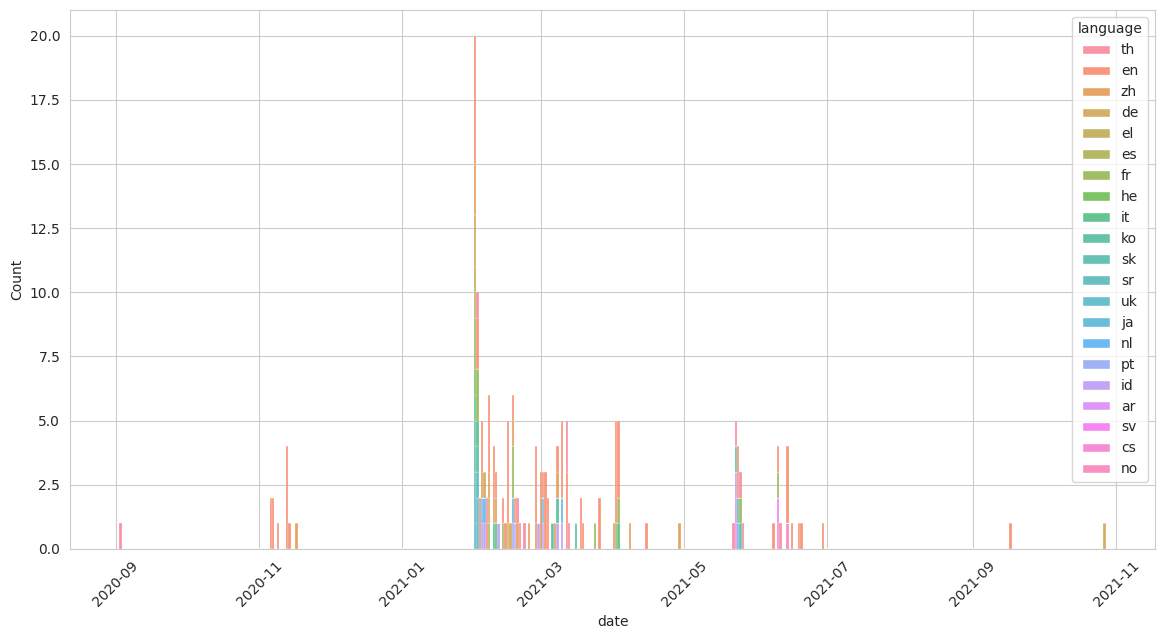

In [17]:
plt.figure(figsize=(14, 7))
sns.histplot(data=grouped_df, x='date', weights='counts', hue=cat, multiple='stack')

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45);

In [59]:
daybags = {}
date_aids = dict(df.groupby('date')['aid'].apply(set))
for date, aIDs in tqdm(sorted(date_aids.items())):
	total = Counter()
	for aID in aIDs:
		total.update(all_bags[aID])
	daybags[date] = total
len(daybags)

  0%|          | 0/413 [00:00<?, ?it/s]

413

In [60]:
dayidf = Counter()
for date, bag in tqdm(daybags.items()):
	dayidf.update(bag.keys())
dayidf = {w: np.log(len(daybags) / f)  for w, f in dayidf.items()}
daytotals = {d: sum(bag.values()) for d, bag in daybags.items()}
daytfidf = {day: Counter({w: f / daytotals[day] * dayidf[w] for w, f in bag.items()}) for day, bag in tqdm(daybags.items())}
len(daytfidf)

  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/413 [00:00<?, ?it/s]

413

In [61]:
target = datetime(2021, 2, 1).date()
# target = datetime(2021, 1, 7).date()
today_aids = date_aids[target]
today_bag = daybags[target]
today_df = df[df['date'] == target]
today_tfidf = daytfidf[target]
importances = today_tfidf

treat_bags_as_sets = True
prior_art_scores = Counter({aID: sum(importances[w] * (1 if treat_bags_as_sets else f) for w, f in all_bags[aID].items() if w in importances) for aID in today_aids})
def article_affinity(aid1, aid2):
	bag1, bag2 = all_bags[aid1], all_bags[aid2]
	return sum(importances[w] * (1 if treat_bags_as_sets else min(f, bag2[w])) for w, f in bag1.items() if w in bag2) / np.sqrt(prior_art_scores[aid1] * prior_art_scores[aid2])
art_imps = list(prior_art_scores.most_common())
aidorder = np.array([c for c, _ in art_imps])

len(today_bag), len(today_aids), sum(len(all_bags[aID]) for aID in today_aids) / len(today_aids)

(11705, 5475, 8.500821917808219)

In [83]:
_linepeek, _linewidth = 120, 120
_numtop = 10
vtitle = lambda aid: textwrap.fill(by_ID[aid].get('en-title', by_ID[aid]['title'])[:_linepeek], width=_linewidth)
vID = lambda aid: by_ID[aid]['ID']
vimp = lambda aid: prior_art_scores[aid]
vtoptokens = lambda aid: ', '.join(w for w in sorted(all_bags[aid], key=lambda w: importances[w], reverse=True)[:_numtop]) + (f' [{len(all_bags[aid])-_numtop} more]' if len(all_bags[aid]) > _numtop else '')
def makerow(aid, *fns):
	return [fn(aid) for fn in fns]

In [84]:
print(tabulate(today_tfidf.most_common(10)))

--------  -----------
suu       0.000752114
kyi       0.000726178
gamestop  0.000673328
aung      0.000665819
1/31/21   0.000638091
wilmore   0.000604732
caleta    0.000374766
reddit    0.000367394
2/1/21    0.000338797
sowon     0.000334245
--------  -----------


In [85]:
print(tabulate([(i, imp, by_ID[aid]['language'], *makerow(aid, vID, vtitle, vtoptokens)) for i, (aid, imp) in enumerate(prior_art_scores.most_common(20))]))
len(art_imps)

--  ----------  --  -------  ------------------------------------------------------------------------------------------------------------------------  -----------------------------------------------------------------------------------
 0  0.00265468  es  2906997  Coup d'état in Myanmar: the army takes power "for a year" and detains Aung San Suu Kyi - Clarín.com                       suu, kyi, aung, myanmar, d'etat, coup, detain, san, army, power [2 more]
 1  0.002617    zh  2909178  [Aung San Suu Kyi was arrested] The Myanmar military said there would be another election in a year. Aung San Suu Ya cal  suu, kyi, aung, myanmar, coup, hotspots, ya, san, kong, hong [18 more]
 2  0.00258517  zh  2910547  Aung San Suu Kyi and many others were detained by the military. What is the current situation in Yangon, Myanmar? _Headq  suu, kyi, aung, myanmar, yangon, detain, san, headquarters, military, many [2 more]
 3  0.00256042  sk  2908388  Putsch in Myanmar. What Aung San Suu Kyi told Pravda ab

5475

In [ ]:
# links = Counter({(aid1, aid2): article_affinity(aid1, aid2) for aid1 in tqdm(today_aids) for aid2 in today_aids if aid1 < aid2})
# links = Counter({(aid1, aid2): f for (aid1, aid2), f in links.items() if f > 0.})
# G = nx.Graph()
# G.add_edges_from((aid1, aid2, {'weight': f}) for (aid1, aid2), f in links.items() if f > 1e-8)
# G.add_nodes_from(today_aids)
# # len(G), len(G.edges)

In [86]:
def topk_ngrams(ordered_keywords, n=2, k=10):
	assert len(ordered_keywords) >= n, f'Not enough tokens in bag: {len(ordered_keywords)} < {n}: {ordered_keywords}'
	return [frozenset(ws) for ws in islice(
		sorted(combinations(ordered_keywords, n), key=lambda ws: sum(importances[w] for w in ws), reverse=True), k)]
def ngram_shells(keywords, num_shells=3, k=10):
	most = min(num_shells, len(keywords))
	content = [set(topk_ngrams(keywords, n=i, k=k)) for i in range(1, most + 1)]
	for _ in range(most, num_shells):
		content.append(set())
	return content
def has_hits(aids, segs):
	return any(all(w in art_keywords[aid] for w in seg) for aid in aids for seg in segs)
def find_hits(aids, segs):
	hits = {}
	for aid in aids:
		for seg in segs:
			if all(w in art_keywords[aid] for w in seg):
				hits.setdefault(seg, []).append(aid)
	return hits
def segs2keywords(segs):
	return sorted(set(w for seg in segs for w in seg), key=lambda w: importances[w], reverse=True)
def generate_candidates(tier, kws, members=None, num_kw=10, num_member=10):
	cands = set()
	if len(kws) >= tier:
		cands.update(topk_ngrams(kws, n=tier, k=num_kw))
	if members and len(members) and num_member:
		member_cands = Counter()
		for aid in members:
			member_cands.update(topk_ngrams(art_keywords[aid], n=tier, k=num_kw))
		for seg, _ in member_cands.most_common(num_member):
			cands.add(seg)
	return cands
def mainline_cluster_tiers(center, options, starting_tier=7, min_tier=2, num_kw=10, num_member=10):
	kws = art_keywords[center]
	members = set()

	known_tokens = set()
	tokens = {}
	tiers = {}
	trace = Counter()
	remaining = list(options)
	if center in remaining:
		remaining.remove(center)
	assert min_tier >= 1, f'Minimum tier must be at least 1: {min_tier}'
	for tier in range(starting_tier, min_tier - 1, -1):
		if not len(remaining):
			break

		cands = generate_candidates(tier, kws, members=members, num_kw=num_kw, num_member=num_member)
		# print(tier, len(cands))
		trace[tier] = len(cands)
		if not has_hits(remaining, cands):
			continue

		hits = find_hits(remaining, cands)

		gold = {}
		for seg, aids in hits.items():
			for aid in aids:
				gold.setdefault(aid, set()).update(seg)
		tokens[tier] = Counter(w for seq in gold.values() for w in seq if w not in known_tokens)
		kws = segs2keywords(hits.keys())
		known_tokens.update(kws)
		tiers[tier] = set(aid for seg, aids in hits.items() for aid in aids)
		members.update(tiers[tier])
		remaining = [aid for aid in remaining if aid not in members]

	return tokens, tiers, trace

In [89]:
art_keywords = {aid: [w for w in sorted(all_bags[aid], key=lambda w: importances[w], reverse=True) if importances[w] > 1e-8] for aid in aidorder}
dayshells = {aid: ngram_shells(art_keywords[aid], num_shells=7) for aid in tqdm(aidorder)}
len(aidorder), aidorder[:8].tolist()

  0%|          | 0/5475 [00:00<?, ?it/s]

(5475,
 [2906997, 2909178, 2910547, 2908388, 2911829, 2907304, 2908083, 2908506])

In [118]:
# full_clusters = {}
# todo = aidorder.tolist()
# total = len(todo)
# itr = tqdm(total=total)
# while len(todo):
# 	center = todo[0]
# 	tokens, tiers, trace = mainline_cluster_tiers(center, todo, starting_tier=7, min_tier=3, num_kw=200, num_member=200)
# 	prev = len(todo)
# 	for aids in tiers.values():
# 		todo = [aid for aid in todo if aid not in aids]
# 	if center in todo:
# 		todo.remove(center)
# 	itr.update(prev - len(todo))
# 	full_clusters[center] = {'tokens': tokens, 'tiers': tiers, 'trace': trace}
# 
# save_json({center: {'tokens': info['tokens'], 'tiers': {t:list(aids) for t, aids in info['tiers'].items()}, 'trace': info['trace']} for center, info in full_clusters.items()}, 
# 		  root/'mainline_keyword_clusters_3_2021-02-01.json')
full_clusters = load_json(root / 'mainline_keyword_clusters_2021-02-01.json')
full_clusters = load_json(root / 'mainline_keyword_clusters_3_2021-02-01.json')
full_clusters = {int(center): {'tokens': {int(t): Counter(ws) for t, ws in info['tokens'].items()},
							   'tiers': {int(t): set(aids) for t, aids in info['tiers'].items()},
							   'trace': Counter({int(t): n for t, n in info['trace'].items()})}
				 for center, info in full_clusters.items()}
len(full_clusters)

  0%|          | 0/5475 [00:00<?, ?it/s]

4806

In [119]:
signatures = {}
for center, info in full_clusters.items():
	features = Counter()
	for tier, tokens in info['tokens'].items():
		features.update(tokens)
	signatures[center] = features
claids = {center: set(aid for aids in info['tiers'].values() for aid in aids) for center, info in full_clusters.items()}
claidcnts = Counter({center: len(aids) for center, aids in claids.items()})
# print(tabulate([center, len(aids), by_ID[center].get('en-title', by_ID[center]['title'])] for center, aids in claids[:10]))
print(tabulate([center, cnt, vtitle(center),
				', '.join(w for w, _ in signatures[center].most_common())] for center, cnt in
			   claidcnts.most_common(20)))

-------  --  ------------------------------------------------------------------------------------------------------------------------  -------------------------------------------------------------------------------------------
2906997  32  Coup d'état in Myanmar: the army takes power "for a year" and detains Aung San Suu Kyi - Clarín.com                       kyi, san, myanmar, coup, aung, suu, detain, arrest, military, army, economic, d'etat, burma
2907603  20  Meghan Markle's rep slams 'clickbait' report saying she removed name from Archie's birth certificate - News24             birth, meghan, certificate, archie, markle, son, palace, rep, slams, erase, row
2911154  19  Liverpool can exploit Premier League rule with Ozan Kabak transfer after Ben Davies deal - Mirror Online                  schalke, agree, deal, liverpool, transfer, kabak, ozan, ben, davies, centre, reds
2907159  17  iCloud Passwords: Apple's official Chrome extension for direct access to iCloud Keychain - Techgear  

In [108]:
# finds = Counter({c: len(claids[c]) for c, toks in signatures.items() if 'elon' in toks})
# print(tabulate([(c, num + 1, '\n'.join(by_ID[x].get('en-title', by_ID[x]['title'])[:160] for x in [c, *claids[c]]),
# 				 '\n'.join(by_ID[x]['language'] for x in [c, *claids[c]]),
# 				 ', '.join(f'{w}:{f}' for w, f in signatures[c].most_common())) for c, num in finds.most_common()]))

In [159]:
crs = 2906997
# crs = 2905115
# crs = 2911138
# crs = 2905545
crs = 2907603

info = full_clusters[crs]
tokens, tiers, trace = info['tokens'], info['tiers'], info['trace']
base = signatures[crs]
print(base)
print(tabulate([(tier, aid, textwrap.fill(by_ID[aid].get('en-title', by_ID[aid]['title']), 150), by_ID[aid]['language'],
				 ', '.join(art_keywords[aid][:10])) for tier in ['X', *sorted(tiers.keys(), reverse=True)] for aid in
				tiers.get(tier, [crs])]))
sum(len(vs) for vs in tiers.values()) + 1

Counter({'birth': 9, 'meghan': 9, 'certificate': 9, 'archie': 8, 'markle': 8, 'son': 5, 'palace': 2, 'rep': 1, 'slams': 1, 'erase': 1, 'row': 1})
-  -------  ---------------------------------------------------------------------------------------------------------------------------------------------------  --  ---------------------------------------------------------------------------------------
X  2907603  Meghan Markle's rep slams 'clickbait' report saying she removed name from Archie's birth certificate - News24                                        en  archie, clickbait, rep, slams, certificate, markle, meghan, birth
5  2908226  Meghan Markle sets the record straight: Buckingham's decision for Archie's birth certificate - Closer France                                         fr  archie, buckingham, certificate, markle, meghan, straight, birth
5  2911235  Meghan Markles rep slams report claiming she changed her name on sons birth certificate - Republic World                        

21

In [122]:
# related = Counter(
# 	{center: sum((base[w] if w in base else 0) * f for w, f in sig.items()) for center, sig in signatures.items() if
# 	 center != crs})
# related = Counter({center: num for center, num in related.items() if num > 0 and center != crs})
# print(tabulate([c, n, ', '.join(set(signatures[crs]) & set(signatures[c])),
# 				'\n'.join(by_ID[x]['language'] for x in [c, *claids[c]]),
# 				'\n'.join(by_ID[x].get('en-title', by_ID[x]['title'])[:200] for x in [c, *claids[c]]),
# 				] for c, n in related.most_common(10)))
# len(related)

In [160]:
freqs = Counter({w: len([aid for aid in [crs, *claids[crs]] if w in all_bags[aid]]) for w in base})
freqs = Counter({w: f for w, f in freqs.items() if f > 0})
print(freqs)

Counter({'meghan': 21, 'birth': 19, 'certificate': 19, 'markle': 16, 'archie': 12, 'son': 7, 'palace': 5, 'rep': 2, 'slams': 2, 'erase': 2, 'row': 2})


In [163]:
den = sum(freqs.values())
def compute_score(aid):
	return sum(f for w, f in freqs.items() if w in all_bags[aid]) / den
scores = Counter({aid: compute_score(aid) for aid in [crs, *claids[crs]]})
pct_threshold = int( 0.8 * len(scores))
threshold = sorted(scores.values(), reverse=True)[pct_threshold]
print(tabulate([(aid, score, vtitle(aid)) for aid, score in (scores.most_common(5) + scores.most_common()[-5:])]))
threshold

-------  --------  -----------------------------------------------------------------------------------------------------------------------
2911758  0.925234  Meghan Markle accuses Buckingham Palace of removing her first names from her son Archie's birth certificate - RT Arabic
2906904  0.878505  Meghan Markle blames palace for erasing her first names from Archie's birth certificate - Sky News Australia
2907603  0.850467  Meghan Markle's rep slams 'clickbait' report saying she removed name from Archie's birth certificate - News24
2906378  0.813084  Meghan Markle Didn't Change Her Name On Archie's Birth Certificate - Access
2907539  0.813084  Meghan Markle accused of removing her name from Archie's birth certificate, here are the facts - Haibunda
2911235  0.654206  Meghan Markles rep slams report claiming she changed her name on sons birth certificate - Republic World
2911373  0.598131  Meghan: 'Change of name on birth certificate had to be done by the palace' - Telegraaf.nl
2910698  0.5

0.6542056074766355

In [164]:
hits = Counter()
for aid in tqdm(by_ID):
	if aid is not scores:
		score = compute_score(aid)
		if score > threshold:
			hits[aid] = score
print(tabulate([(aid, score, vtitle(aid)) for aid, score in hits.most_common(20)]))
len(hits)

  0%|          | 0/4719199 [00:00<?, ?it/s]

-------  --------  ------------------------------------------------------------------------------------------------------------------------
2911758  0.925234  Meghan Markle accuses Buckingham Palace of removing her first names from her son Archie's birth certificate - RT Arabic
2904705  0.878505  Meghan Markle removes her name from her son Archie's birth certificate - RT Arabic
2906904  0.878505  Meghan Markle blames palace for erasing her first names from Archie's birth certificate - Sky News Australia
3296997  0.878505  Surprise - Meghan Markle's name is not on the birth certificate of Archie, Duke of Sussex's son - Jauns.lv
2907603  0.850467  Meghan Markle's rep slams 'clickbait' report saying she removed name from Archie's birth certificate - News24
2908226  0.813084  Meghan Markle sets the record straight: Buckingham's decision for Archie's birth certificate - Closer France
2907539  0.813084  Meghan Markle accused of removing her name from Archie's birth certificate, here are the 

41

In [168]:
sub = df[df['aid'].isin(set([crs, *hits, *claids[crs]]))]
sub['score'] = sub['aid'].map(hits)
sub = sub.sort_values('score', ascending=True)
sub

/tmp/ipykernel_3197586/2335402035.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['score'] = sub['aid'].map(hits)


aid                                              title  \
2793900  2911373  Meghan: 'Change of name on birth certificate h...   
1908187  2910775  Meghan Markle still controlled by the royal fa...   
4315507  2911235  Meghan Markles rep slams report claiming she c...   
527282   2910260  Meghan Markle, the Palace cancels her name and...   
5725256  2910698  'I didn't put Empress of World on mine' Hartle...   
...          ...                                                ...   
4885288  3296997  Surprise - Meghan Markle's name is not on the ...   
3008007  2906904  Meghan Markle blames palace for erasing her fi...   
1731874  2904705  Meghan Markle removes her name from her son Ar...   
4885286  3296997  Surprise - Meghan Markle's name is not on the ...   
1732070  2911758  Meghan Markle accuses Buckingham Palace of rem...   

                     source language               collectedAt location  \
2793900        Telegraaf.nl       nl 2021-02-01 14:11:00+00:00       nl   
1908187               melty       fr 2021-02-01 14:11:00+00:00       ma   
4315507      Republic World       en 2021-02-01 14:11:00+00:00       ng   
527282             Dilei.it       it 2021-02-01 14:11:00+00:00       it   
5725256             Express       en 2021-02-01 14:11:00+00:00       gb   
...                     ...      ...                       ...      ...   
4885288            Jauns.lv       lv 2021-05-21 09:15:00+00:00       lv   
3008007  Sky News Australia       en 2021-02-01 14:11:00+00:00       au   
1731874                  RT       ar 2021-01-31 10:31:00+00:00       ae   
4885286            Jauns.lv       lv 2021-04-03 08:28:00+00:00       lv   
1732070                  RT       ar 2021-02-01 14:11:00+00:00       ae   

              category          iid        date     score  
2793900  entertainment  2911373-000  2021-02-01  0.000000  
1908187  entertainment  2910775-000  2021-02-01  0.000000  
4315507  entertainment  2911235-000  2021-02-01  0.000000  
527282   entertainment  2910260-000  2021-02-01  0.000000  
5725256  entertainment  2910698-000  2021-02-01  0.000000  
...                ...          ...         ...       ...  
4885288  entertainment  3296997-003  2021-05-21  0.878505  
3008007  entertainment  2906904-000  2021-02-01  0.878505  
1731874  entertainment  2904705-000  2021-01-31  0.878505  
4885286  entertainment  3296997-001  2021-04-03  0.878505  
1732070  entertainment  2911758-000  2021-02-01  0.925234  

[61 rows x 10 columns]

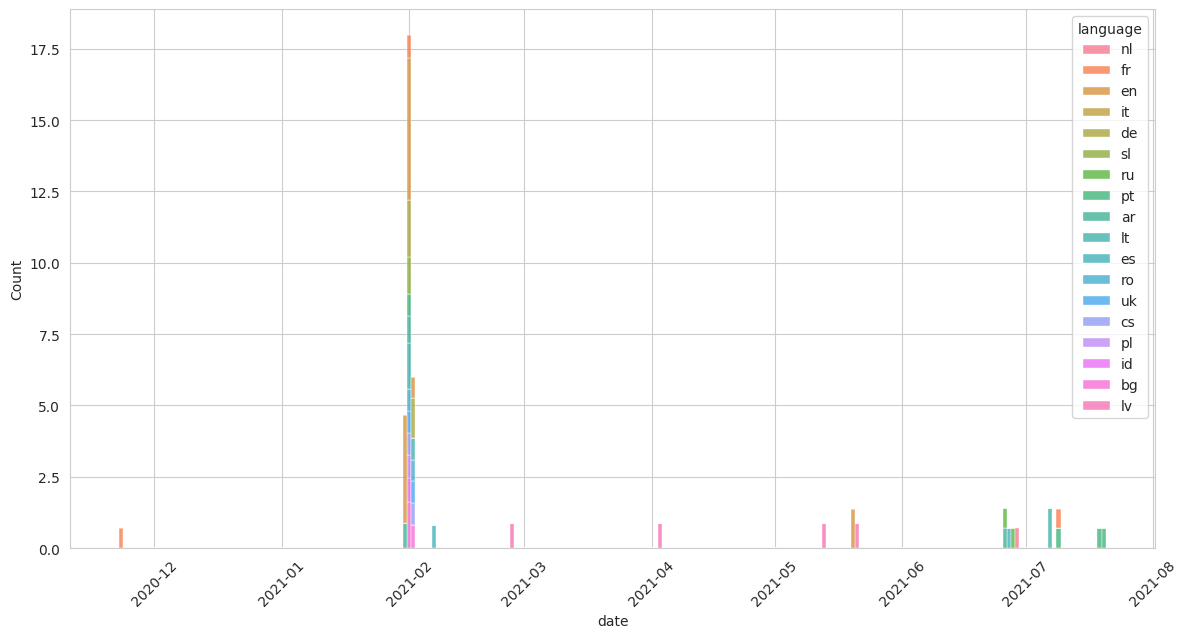

In [169]:

plt.figure(figsize=(14, 7))

sns.histplot(data=sub, x='date', weights='score', hue='language', multiple='stack')

# cat = 'language'
# grouped_df = sub.groupby(['date', cat]).size().reset_index(name='counts')
# plt.figure(figsize=(14, 7))
# sns.histplot(data=grouped_df, x='date', weights='counts', hue=cat, multiple='stack')

plt.xticks(rotation=45);

In [174]:
cluster_root = root / 'clusterings'
cluster_root.mkdir(exist_ok=True)

In [178]:
for dateidx, target in enumerate(daybags):

	today_aids = date_aids[target]
	today_bag = daybags[target]
	# today_df = df[df['date'] == target]
	today_tfidf = daytfidf[target]
	importances = today_tfidf
	
	treat_bags_as_sets = True
	prior_art_scores = Counter({aID: sum(importances[w] * (1 if treat_bags_as_sets else f) for w, f in all_bags[aID].items() if w in importances) for aID in today_aids})
	def article_affinity(aid1, aid2):
		bag1, bag2 = all_bags[aid1], all_bags[aid2]
		return sum(importances[w] * (1 if treat_bags_as_sets else min(f, bag2[w])) for w, f in bag1.items() if w in bag2) / np.sqrt(prior_art_scores[aid1] * prior_art_scores[aid2])
	art_imps = list(prior_art_scores.most_common())
	aidorder = np.array([c for c, _ in art_imps])
	
	art_keywords = {aid: [w for w in sorted(all_bags[aid], key=lambda w: importances[w], reverse=True) if importances[w] > 1e-8] for aid in aidorder}
	
	datstr = target.strftime('%Y-%m-%d')
	
	full_clusters = {}
	todo = aidorder.tolist()
	total = len(todo)
	itr = tqdm(total=total)
	itr.set_description(f'{dateidx+1}/{len(daybags)} - {datstr}')
	while len(todo):
		center = todo[0]
		tokens, tiers, trace = mainline_cluster_tiers(center, todo, starting_tier=7, min_tier=3, num_kw=200, num_member=200)
		prev = len(todo)
		for aids in tiers.values():
			todo = [aid for aid in todo if aid not in aids]
		if center in todo:
			todo.remove(center)
		itr.update(prev - len(todo))
		full_clusters[center] = {'tokens': tokens, 'tiers': tiers, 'trace': trace}
	
	itr.close()
	
	save_json({center: {'tokens': info['tokens'], 'tiers': {t:list(aids) for t, aids in info['tiers'].items()}, 'trace': info['trace']} for center, info in full_clusters.items()}, 
		  cluster_root/f'clusters_{datstr}.json')
# full_clusters = load_json(root / 'mainline_keyword_clusters_2021-02-01.json')

  0%|          | 0/3998 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [258]:
c = random.choice(list(today_aids))
# c = 2906997
# c = 2909198
# c = 2911138
# c = 2906738

neighbors = Counter({(v if u == c else u): w for u,v,w in G.edges(c, data='weight')})
narts = {aid:by_ID[aid] for aid in neighbors}
len(neighbors)

6

In [259]:
# print(tabulate(neighbors.most_common(10)))
view_article(by_ID[c])
print(tabulate([(i, aff, narts[aid]['language'], narts[aid]['instances'][0]['collectedAt'].split('T')[0], narts[aid].get('en-title', narts[aid]['title'])) for i, (aid, aff) in enumerate(neighbors.most_common(100))]))

English Title: 'Is planning for 2021 possible?: how to reorganize life in the face of uncertainty - Diario El Día'
Spanish Title: '¿Planificar el 2021 es posible?: cómo reorganizar la vida ante la incertidumbre - Diario El Día'
Categories: <science>  ---   'Argentina' (01 Feb21)  ---  Diario El Dia. www.eldia.com
-  ---------  --  ----------  ------------------------------------------------------------------------------------------------------------
0  0.0705122  es  2021-02-01  Prepaid medicine goes up: how much will the increase be - El Diario Nuevo Dia
1  0.0668101  he  2021-02-01  Uncertainty in Maccabi Tel Aviv: "They don't know what game to prepare for now" - ynet.co.il
2  0.0534963  es  2021-02-01  AMLO's mishandling of COVID information caused unnecessary uncertainty, they say - SinEmbargo
3  0.0435313  pt  2021-02-01  Petrópolis has 153 people hospitalized with COVID-19 - Jornal O Dia
4  0.0284235  pt  2021-02-01  Grupo DIA closes Clarel stores in Portugal until the end of Mar

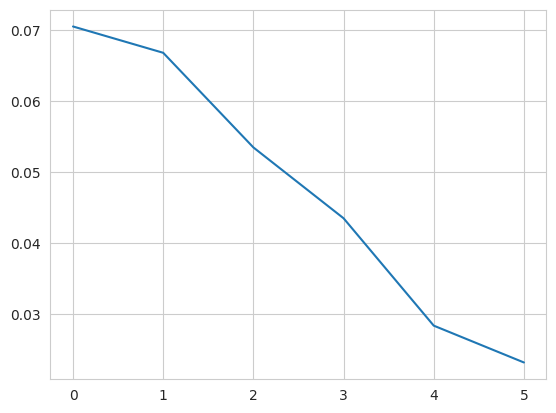

In [260]:
plt.plot(sorted(neighbors.values(), reverse=True))

5475

In [23]:
# xs = np.array([c for c, _ in art_imps[:400]])
rawsims = [sorted([w for u,v,w in G.edges(c, data='weight')], reverse=True) for c in aidorder]
longest = max(len(s) for s in rawsims)
sims = np.zeros((len(rawsims), longest))
for i, s in enumerate(rawsims):
	sims[i, :len(s)] = s
sims.shape

(5475, 324)

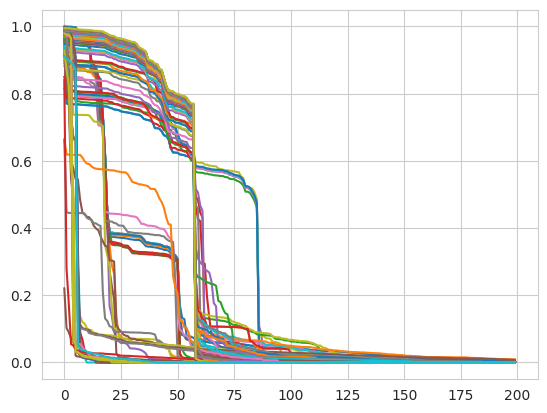

In [24]:
plt.plot(sims[:100,:200].T);

In [25]:
from sklearn.cluster import DBSCAN

In [26]:
cus = DBSCAN(eps=0.001, min_samples=2, metric='cosine')
cus.fit(sims);

In [27]:
lbls = cus.labels_
counts = Counter(lbls)
print(counts)

Counter({-1: 4450, 14: 163, 25: 101, 21: 71, 2: 47, 83: 35, 12: 25, 40: 20, 19: 18, 18: 17, 56: 14, 9: 12, 23: 12, 103: 11, 34: 10, 47: 10, 0: 9, 39: 8, 52: 8, 79: 8, 97: 8, 43: 7, 144: 7, 3: 6, 6: 6, 28: 6, 67: 6, 8: 5, 16: 5, 29: 5, 33: 5, 62: 5, 78: 5, 107: 5, 143: 5, 156: 5, 157: 5, 1: 4, 11: 4, 13: 4, 38: 4, 48: 4, 49: 4, 53: 4, 85: 4, 93: 4, 132: 4, 10: 3, 17: 3, 26: 3, 27: 3, 30: 3, 31: 3, 37: 3, 51: 3, 57: 3, 59: 3, 61: 3, 68: 3, 72: 3, 76: 3, 84: 3, 86: 3, 92: 3, 95: 3, 109: 3, 112: 3, 121: 3, 122: 3, 146: 3, 151: 3, 155: 3, 176: 3, 4: 2, 5: 2, 7: 2, 15: 2, 20: 2, 22: 2, 24: 2, 32: 2, 35: 2, 36: 2, 41: 2, 42: 2, 44: 2, 45: 2, 46: 2, 50: 2, 54: 2, 55: 2, 58: 2, 60: 2, 63: 2, 64: 2, 65: 2, 66: 2, 69: 2, 70: 2, 71: 2, 73: 2, 74: 2, 75: 2, 77: 2, 80: 2, 81: 2, 82: 2, 87: 2, 88: 2, 89: 2, 90: 2, 91: 2, 94: 2, 96: 2, 98: 2, 99: 2, 100: 2, 101: 2, 102: 2, 104: 2, 105: 2, 106: 2, 108: 2, 110: 2, 111: 2, 113: 2, 114: 2, 115: 2, 116: 2, 117: 2, 118: 2, 119: 2, 120: 2, 123: 2, 124: 2, 12

In [28]:
art_clusters = {cidx: aidorder[lbls==cidx].tolist() for cidx in set(lbls) if cidx >= 0}
tbl = []
for cidx, aids in art_clusters.items():
	
	arts = [by_ID[aid] for aid in aids]
	
	langs = Counter([art['language'] for art in arts])
	cats = Counter([i['category'] for art in arts for i in art['instances']])
	locs = Counter([i['location'] for art in arts for i in art['instances']])
	
	imp = sum(prior_art_scores[aid] for aid in aids)
	
	toptok = Counter()
	for art in arts:
		for w in all_bags[art['ID']]:
			toptok[w] += importances[w]
	
	tbl.append([
		cidx,
		len(aids),
		imp,
		', '.join(f'{token!r}' for token, f in toptok.most_common(10)),
		', '.join(f'{lang}:{f}' for lang, f in langs.most_common()),
		', '.join(f'{cat[:3]}:{f}' for cat, f in cats.most_common()),
		# ', '.join(f'{loc_names[loc]}:{f}' for loc, f in locs.most_common()),
	])
print(tabulate(sorted(tbl, key=lambda row: row[2], reverse=True)))

---  ---  -----------  ------------------------------------------------------------------------------------------------------------------------------------  --------------------------------------------------------------------------------------------------------------------------------------------------------  -------------------------------------------------------
  2   47  0.0175542    'gamestop', 'melvin', 'verbio', 'robinhood', 'hotstockreport', 'ehang', 'sollner', 'storm|white', 'inwestorow', 'brokerage|apple'     en:9, es:8, de:7, zh:3, sv:3, pl:2, fr:2, tr:1, no:1, he:1, pt:1, nl:1, th:1, it:1, ru:1, uk:1, lt:1, hu:1, ar:1, el:1                                    bus:49, tec:10, gen:9, ent:1
  0    9  0.0113103    'suu', 'kyi', 'aung', 'myanmar', 'coup', "d'etat", 'clarin.com', 'hotspots', 'san', 'detain'                                          en:3, es:1, zh:1, ko:1, uk:1, sr:1, de:1                                                                                                

47
-  -----------  --  ----------  -----------------------------------------------------------------------------------------------------------------------------
0  0.000347791  en  2021-02-01  Silver prices soar as GameStop retail frenzy moves on to metal - The Irish Times
1  0.000335652  es  2021-02-01  The controversial decision of the platforms to operate on the stock market after the enormous rise of GameStop - Ambiente.com
2  0.000348782  he  2021-02-01  The increases in GameStop made Robin Hood raise a billion dollars - Global Markets - Bizportal
3  0.000333464  pl  2021-02-01  GameStop, what is it? Games and panic on the stock exchange - TVP Info
4  0.000337182  it  2021-02-01  The GameStop swing may repeat itself: here's how to protect your wallet - La Stampa
5  0.000334212  en  2021-02-01  GameStop: When will the bubble burst, and will it take down the rest of the market? - Newshub
6  0.000339268  nl  2021-02-01  After GameStop, smaller investors are now focusing on silver - N

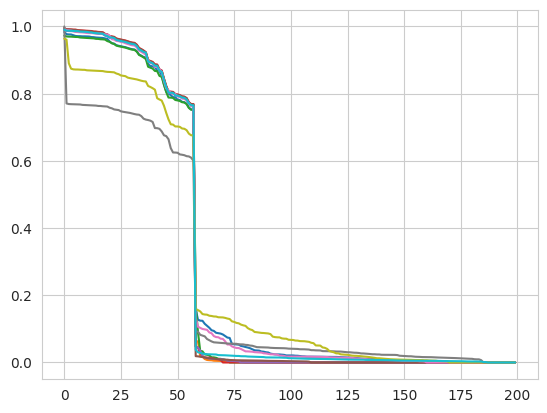

In [137]:
cidx = 2
sel = np.arange(len(lbls))[lbls==cidx]
sel = np.random.choice(sel, min(10, len(sel)), replace=False)
print(counts[cidx])
plt.plot(sims[sel,:200].T);

seq = aidorder[sel]
print(tabulate([(i, prior_art_scores[aid], by_ID[aid]['language'], by_ID[aid]['instances'][0]['collectedAt'].split('T')[0], by_ID[aid].get('en-title', by_ID[aid]['title'])) for i, aid in enumerate(seq)]))

In [31]:
# importances

In [32]:
headlines = [
    "Stock prices reach new heights",
    "Local elections see surprising results",
    "School board plans new building project",
    "Celebrity scandal shocks fans",
    "Economy shows signs of growth",
    "New movie release breaks box office records",
    "Scientists discover new species in the rainforest",
    "Sports team makes a comeback",
    "Technology companies agree on a standard",
    "Researchers find cure for rare disease"
]

# Function to get the vector for a headline
def get_headline_vector(headline):
    # Tokenize the headline
    words = word_tokenize(headline.lower())
    # Initialize an empty list to store vectors
    word_vectors_list = []
    # Add the vector for each word to the list
    for word in words:
        if word in word_vectors:
            word_vectors_list.append(word_vectors[word])
    # Compute the average vector for the headline
    if word_vectors_list:
        return np.mean(word_vectors_list, axis=0)
    else:
        return np.zeros(300)

# Vectorize the headlines
headline_vectors = np.array([get_headline_vector(by_ID[aid].get('en-title', by_ID[aid]['title'])) for aid in tqdm(aidorder)])
headline_vectors.shape

  0%|          | 0/5475 [00:00<?, ?it/s]

(5475, 300)

In [33]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('ashraq/tsdae-bert-base-dv-news-title')

In [35]:
# sentences = ["This is an example sentence", "Each sentence is converted"]
sentences = [by_ID[aid].get('en-title', by_ID[aid]['title']) for aid in tqdm(aidorder)]
headline_vectors2 = model.encode(sentences)
headline_vectors2.shape

  0%|          | 0/5475 [00:00<?, ?it/s]

(5475, 768)

In [36]:
from sklearn.cluster import DBSCAN, KMeans, HDBSCAN, MeanShift, AffinityPropagation, SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score, adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score

In [504]:

# # cus = DBSCAN(eps=0.2, min_samples=2, metric='cosine')
# cus = HDBSCAN(min_cluster_size=2, metric='euclidean')
# cus.fit(headline_vectors);
# clusters = cus.labels_
# counts = Counter(clusters)

cluster_results = []
inertias = []
param_values = np.arange(10, 30, 2)
param_values = [5, 10, 15, 20, 25, 30, 50, 100]
# param_values = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

# feats = headline_vectors
# feats = headline_vectors2
feats = sims

param_values = np.array(param_values)
for param in tqdm(param_values):
	# model = AffinityPropagation(damping=param, affinity='euclidean')
	model = KMeans(n_clusters=param, random_state=42)
	# model = SpectralClustering(n_clusters=param, random_state=42)
	model.fit(feats)
	cluster_results.append(model.labels_)
	# inertias.append(model.inertia_)
cluster_results = np.array(cluster_results)
# inertias = np.array(inertias)
sil = np.array([silhouette_score(feats, labels) for labels in cluster_results])
db = np.array([davies_bouldin_score(feats, labels) for labels in cluster_results])
ch = np.array([calinski_harabasz_score(feats, labels) for labels in cluster_results])


# print(f'Inertia: {kmeans.inertia_:.2f}') # lower better
# print(f"Silhouette Score: {silhouette_score(headline_vectors, clusters):.2f}") # higher better (-1 to 1)
# print(f"Davies-Bouldin Score: {davies_bouldin_score(headline_vectors, clusters):.2f}") # lower better (0 to infinity)
# print(f"Calinski-Harabasz Index: {calinski_harabasz_score(headline_vectors, clusters):.2f}") # higher better (0 to infinity)
# print(counts)



  0%|          | 0/8 [00:00<?, ?it/s]

/home/fleeb/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/fleeb/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/fleeb/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/fleeb/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/fleeb/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.

In [45]:
# plt.figure(figsize=(14, 7))
# # plt.plot(param_values, np.log(inertias), '-o', label='Inertia (lower better)')
# # plt.plot(param_values, sil, '-o', label='Silhouette (higher better)')
# plt.plot(param_values, db, '-o', label='Davies-Bouldin (lower better)')
# # plt.plot(param_values, ch, '-o', label='Calinski-Harabasz (higher better)')
# plt.legend()

In [26]:
import umap
import plotly.express as px
import pandas as pd

In [27]:
def greedy_graph_clustering(G, node_order, thumb_factor=1., max_clusters=None):
	num_clusters = 0
	labels = {}
	
	todo_nodes = list(reversed(node_order))
	while len(todo_nodes) and (max_clusters is None or num_clusters < max_clusters):
		cluster_id = num_clusters
		num_clusters += 1
		center = todo_nodes.pop()
		labels[center] = cluster_id
		
		neighbors = [(v if u == center else u, w) for u,v,w in G.edges(center, data='weight')]
		neighbors = sorted(neighbors, key=lambda row: row[1], reverse=True)
		if len(neighbors) < 2:
			continue
		names, weights = zip(*neighbors)
		
		if len(weights) < 2:
			continue
		
		max_change = max([(weights[i] - weights[i+1], i) for i in range(len(weights)-1)])[1]
		for i in range(max_change+1):
			neighbor = names[i]
			if neighbor in todo_nodes:
				todo_nodes.remove(neighbor)
				labels[neighbor] = cluster_id
		
		for candidate in names[max_change+1:]:
			if candidate in labels or candidate not in todo_nodes:
				continue
			options = [(v if u == center else u, w) for u,v,w in G.edges(center, data='weight')]
			pos_wt, neg_wt = 0., 0.
			for v, w in options:
				if labels.get(v) == cluster_id:
					pos_wt += w
				else:
					neg_wt += w
			if thumb_factor * pos_wt > neg_wt:
				todo_nodes.remove(candidate)
				labels[candidate] = cluster_id
		
	return np.array([labels.get(n, -1) for n in node_order])


# treat_bags_as_sets = True
def token_shell_clustering(G, node_order, bags, token_imps, acceptance=0.5, max_clusters=None, treat_as_bags=True):
	num_clusters = 0
	labels = {}
	
	todo_nodes = list(reversed(node_order))
	while len(todo_nodes) and (max_clusters is None or num_clusters < max_clusters):
		cluster_id = num_clusters
		num_clusters += 1
		center = todo_nodes.pop()
		labels[center] = cluster_id
		
		neighbors = [(v if u == center else u, w) for u,v,w in G.edges(center, data='weight')]
		neighbors = sorted(neighbors, key=lambda row: row[1], reverse=True)
		
		core = bags[center]
		
		targets = []
		
		
		
		
		
		
		
		
		
	
	
	pass



In [29]:
set(all_bags[aidorder[0]]) & set(all_bags[aidorder[1]]) & set(all_bags[aidorder[2]])

{'aung', 'kyi', 'myanmar', 'san', 'suu'}

In [30]:
def topk_ngrams(ordered_keywords, n=2, k=10):
	assert len(ordered_keywords) >= n, f'Not enough tokens in bag: {len(ordered_keywords)} < {n}: {ordered_keywords}'
	return [frozenset(ws) for ws in islice(sorted(combinations(ordered_keywords, n), key=lambda ws: sum(importances[w] for w in ws), reverse=True), k)]
def ngram_shells(keywords, num_shells=3, k=10):
	most = min(num_shells, len(keywords))
	content = [set(topk_ngrams(keywords, n=i, k=k)) for i in range(1, most+1)]
	for _ in range(most, num_shells):
		content.append(set())
	return content

In [31]:
art_keywords = {aid: [w for w in sorted(all_bags[aid], key=lambda w: importances[w], reverse=True) if importances[w] > 1e-8] for aid in aidorder}
dayshells = {aid: ngram_shells(art_keywords[aid], num_shells=7) for aid in tqdm(aidorder)}

  0%|          | 0/5475 [00:00<?, ?it/s]

In [384]:
todo = aidorder.tolist()

In [355]:
len(todo), todo[:8]

(5475,
 [2906997, 2909178, 2910547, 2908388, 2911829, 2907304, 2907695, 2908083])

In [32]:
def has_hits(aids, segs):
	return any(all(w in art_keywords[aid] for w in seg) for aid in aids for seg in segs)
def find_hits(aids, segs):
	hits = {}
	for aid in aids:
		for seg in segs:
			if all(w in art_keywords[aid] for w in seg):
				hits.setdefault(seg, []).append(aid)
	return hits
def segs2keywords(segs):
	return sorted(set(w for seg in segs for w in seg), key=lambda w: importances[w], reverse=True)

def generate_candidates(tier, kws, members=None, num_kw=10, num_member=10):
	cands = set()
	if len(kws) >= tier:
		cands.update(topk_ngrams(kws, n=tier, k=num_kw))
	if members and len(members) and num_member:
		member_cands = Counter()
		for aid in members:
			member_cands.update(topk_ngrams(art_keywords[aid], n=tier, k=num_kw))
		for seg, _ in member_cands.most_common(num_member):
			cands.add(seg)
	return cands

In [33]:
def mainline_cluster_tiers(center, options, starting_tier=7, min_tier=2, num_kw=10, num_member=10):
	
	kws = art_keywords[center]
	members = set()
	
	known_tokens = set()
	tokens = {}
	tiers = {}
	trace = Counter()
	remaining = list(options)
	if center in remaining:
		remaining.remove(center)
	assert min_tier >= 1, f'Minimum tier must be at least 1: {min_tier}'
	for tier in range(starting_tier, min_tier-1, -1):
		if not len(remaining):
			break
		
		cands = generate_candidates(tier, kws, members=members, num_kw=num_kw, num_member=num_member)
		# print(tier, len(cands))
		trace[tier] = len(cands)
		if not has_hits(remaining, cands):
			continue
			
		hits = find_hits(remaining, cands)
		
		gold = {}
		for seg, aids in hits.items():
			for aid in aids:
				gold.setdefault(aid, set()).update(seg)
		tokens[tier] = Counter(w for seq in gold.values() for w in seq if w not in known_tokens)
		kws = segs2keywords(hits.keys())
		known_tokens.update(kws)
		tiers[tier] = set(aid for seg, aids in hits.items() for aid in aids)
		members.update(tiers[tier])
		remaining = [aid for aid in remaining if aid not in members]
		
	return tokens, tiers, trace

In [64]:
# full_clusters = {}
# todo = aidorder.tolist()
# total = len(todo)
# itr = tqdm(total=total)
# while len(todo):
# 	center = todo[0]
# 	tokens, tiers, trace = mainline_cluster_tiers(center, todo, starting_tier=7, min_tier=2, num_kw=200, num_member=200)
# 	prev = len(todo)
# 	for aids in tiers.values():
# 		todo = [aid for aid in todo if aid not in aids]
# 	if center in todo:
# 		todo.remove(center)
# 	itr.update(prev - len(todo))
# 	full_clusters[center] = {'tokens': tokens, 'tiers': tiers, 'trace': trace}
# savefull = {center: {'tokens': info['tokens'], 'tiers': {t:list(aids) for t, aids in info['tiers'].items()}, 'trace': info['trace']} for center, info in full_clusters.items()}
# # save_json(savefull, root/'mainline_keyword_clusters_2_2021-02-01.json') # includes tier 2
# save_json(savefull, root/'mainline_keyword_clusters_2021-02-01.json')
full_clusters = load_json(root/'mainline_keyword_clusters_2021-02-01.json')
# full_clusters = load_json(root/'mainline_full_clusters_2021-02-01.json')
full_clusters = {int(center): {'tokens': {int(t): Counter(ws) for t, ws in info['tokens'].items()}, 
							   'tiers': {int(t):set(aids) for t, aids in info['tiers'].items()}, 
							   'trace': Counter({int(t): n for t, n in info['trace'].items()})} 
				 for center, info in full_clusters.items()}
len(full_clusters)

4692

In [66]:
signatures = {}
for center, info in full_clusters.items():
	features = Counter()
	for tier, tokens in info['tokens'].items():
		features.update(tokens)
	signatures[center] = features

In [67]:
claids = {center: set(aid for aids in info['tiers'].values() for aid in aids) for center, info in full_clusters.items()}
claidcnts = Counter({center: len(aids) for center, aids in claids.items()})
# print(tabulate([center, len(aids), by_ID[center].get('en-title', by_ID[center]['title'])] for center, aids in claids[:10]))
print(tabulate([center, cnt, by_ID[center].get('en-title', by_ID[center]['title'])[:100], ', '.join(w for w, _ in signatures[center].most_common())] for center, cnt in claidcnts.most_common(20)))

-------  --  -----------------------------------------------------------------------------------------------------  ----------------------------------------------------------------------------------------------
2906997  31  Coup d'état in Myanmar: the army takes power "for a year" and detains Aung San Suu Kyi - Clarín.com    myanmar, kyi, aung, coup, suu, san, detain, arrest, military, army, economic
2907603  20  Meghan Markle's rep slams 'clickbait' report saying she removed name from Archie's birth certificate   certificate, birth, meghan, markle, archie, son, palace, rep, slams, row
2907416  17  iCloud Keychain comes to Windows via Chrome extension - iCulture                                       password, icloud, extension, chrome, keychain, windows, passwords
2905545  14  BTC billionaire Tim Draper to Elon Musk: I'd buy the Tesla Cybertruck with Bitcoin By Cointelegraph    musk, elon, bitcoin, tesla, cointelegraph, investing.com
2905889  13  Bitcoin 'ascendant' as GameStop saga un

In [87]:
finds = Counter({c: len(claids[c]) for c, toks in signatures.items() if 'pfizer' in toks})
print(tabulate([(c, num+1, '\n'.join(by_ID[x].get('en-title', by_ID[x]['title'])[:160] for x in [c, *claids[c]]), '\n'.join(by_ID[x]['language'] for x in [c, *claids[c]]), ', '.join(f'{w}:{f}' for w, f in signatures[c].most_common())) for c, num in finds.most_common()]))

-------  --  ----------------------------------------------------------------------------------------------------------------------------------------------------------------  --  --------------------------------------------------------
2910370  11  Covid vaccines, Bayer will produce Curevac. Pfizer will deliver 75 million doses in the second quarter - Il Fatto Quotidiano                                      it  additional:4, dose:2, deliver:2, 75:2, pfizer:2, irish:1
             Coronavirus latest: BioNTech to deliver 75m more vaccine doses to EU by July - Financial Times                                                                    en
             BioNTech/Pfizer promise up to 75 million additional doses of their vaccine to the EU - Skai.gr                                                                    el
             Coronavirus in the world: BioNTech and Pfizer promise up to 75 million additional doses... - dh.be                                                             

In [93]:
crs = 2910370
# crs = 2909411
crs = 2905545
crs = 2910650

info = full_clusters[crs]
tokens, tiers, trace = info['tokens'], info['tiers'], info['trace']
base = signatures[crs]
print(base)
print(tabulate([(tier, aid, by_ID[aid].get('en-title', by_ID[aid]['title'])[:120], by_ID[aid]['language'], ', '.join(art_keywords[aid][:10])) for tier in ['X', *sorted(tiers.keys(), reverse=True)] for aid in tiers.get(tier, [crs])]))

Counter({'brain': 1, 'musk': 1, 'implant': 1, 'monkey': 1, 'elon': 1})
-  -------  ------------------------------------------------------------------------------------------------------------  --  --------------------------------------------
X  2910650  Elon Musk claims he has 'a monkey with a brain implant that can play video games with his mind' - Daily Mail  en  implant, monkey, musk, elon, brain, mind
5  2911895  Elon Musk claims he has a monkey with brain implant to play video games - Republic World                      en  implant, monkey, musk, elon, brain
4  2909336  Elon Musk says he wired up a monkey’s brain to play video games - News24                                      en  monkey, news24, musk, wire, elon, brain
4  2908240  Elon Musk says he wired up a monkey's brain to play video games - The Star Online                             en  monkey, musk, wire, elon, brain
4  2908551  Elon Musk's Latest: "Happy Monkey" With Wires In Brain To Play Video Game - NDTV              

In [95]:
related = Counter({center: sum((base[w] if w in base else 0) * f for w, f in sig.items()) for center, sig in signatures.items() if center != crs})
related = Counter({center: num for center, num in related.items() if num > 0 and center != crs})
print(tabulate([c, n, ', '.join(set(signatures[crs]) & set(signatures[c])), '\n'.join(by_ID[x].get('en-title', by_ID[x]['title'])[:200] for x in [c, *claids[c]]), '\n'.join(by_ID[x]['language'] for x in [c, *claids[c]])] for c, n in related.most_common(10)))
len(related)

-------  --  ----------  ----------------------------------------------------------------------------------------------------------------------------------------------------------  --
2905545  25  musk, elon  BTC billionaire Tim Draper to Elon Musk: I'd buy the Tesla Cybertruck with Bitcoin By Cointelegraph - Investing.com                                         en
                         Elon Musk gives his predictions on Bitcoin - lalibre.be                                                                                                     fr
                         Tesla boss Elon Musk waved for a moment with the price of bitcoin - Aktuality.sk                                                                            sk
                         What do we say to those who bought Bitcoin above 40 thousand dollars? By CoinTelegraph - Investing.com Spain                                                es
                         Elon Musk bets on bitcoin - Insider.gr                 

5

In [46]:
tokens

{3: Counter({'reddit': 6,
          'army': 5,
          'silver': 5,
          'australian': 1,
          'financial': 1})}

In [408]:
# center = aidorder[0]
# center = aidorder[19]

print(by_ID[center].get('en-title', by_ID[center]['title']))
print(art_keywords[center])

# shells = dayshells[center]

neighbors = [(v if u == center else u, w) for u,v,w in G.edges(center, data='weight')]
neighbors = sorted(neighbors, key=lambda row: row[1], reverse=True)
naids = [aid for aid, _ in neighbors]
# agreement = np.array([[len(shells[shellidx] & dayshells[nid][shellidx]) for nid, _ in neighbors] for shellidx in range(len(shells))])
# agreement.shape

tokens, tiers, trace = mainline_cluster_tiers(center, todo, starting_tier=7, min_tier=3, num_kw=200, num_member=200)
# for aids in tiers.values():
# 	todo = [aid for aid in todo if aid not in aids]
# if center in todo:
# 	todo.remove(center)
max(tiers) if len(tiers) else None, list(tiers.keys()), sum(len(tiers[tier]) for tier in tiers)

GameStop stock: Defiant WallStreetBets Redditors buy billboard on Times Square, say they won't sell - Newshub
['gamestop', 'wallstreetbet', 'redditors', 'defiant', 'billboard', 'sell', 'newshub', 'square', 'wo']
7 36
6 84
5 126


KeyboardInterrupt: 

In [405]:
# print(tabulate([(tier, len(tiers[tier]), ', '.join(map(str, tiers[tier]))) for tier in sorted(tiers.keys())]))
# print(tabulate([(tier, ', '.join(map(str, tokens[tier]))) for tier in sorted(tokens.keys())]))
print(tokens)
print(tabulate([(tier, aid, by_ID[aid].get('en-title', by_ID[aid]['title'])[:150], by_ID[aid]['language'], ', '.join(art_keywords[aid][:5])) for tier in sorted(tiers.keys(), reverse=True) for aid in tiers[tier]]))

{}


In [277]:
cands = generate_candidates(7, art_keywords[center])
has_hits(naids, cands)

False

In [273]:
cands = generate_candidates(6, art_keywords[center])
hits = find_hits(naids, cands)
print(tabulate([(seg, len(aids), ', '.join(map(str, aids))) for seg, aids in hits.items()]))
# hits = Counter([seg for seg in shells[-2] for naid in naids if all(w in art_keywords[naid] for w in seg)])
# print(tabulate(hits.most_common(10)))

--------------------------------------------------------------  -  ----------------------------------------------------------------------
frozenset({'myanmar', 'aung', 'suu', 'coup', 'kyi', 'san'})     8  2908506, 2908083, 2907695, 2907304, 2907976, 2911829, 2910175, 2909178
frozenset({'myanmar', 'aung', 'suu', 'coup', 'kyi', 'detain'})  5  2908506, 2908083, 2907695, 2907304, 2911829
frozenset({'myanmar', 'aung', 'suu', 'army', 'coup', 'kyi'})    1  2907976
--------------------------------------------------------------  -  ----------------------------------------------------------------------


In [274]:
completed = set(aid for seg, aids in hits.items() for aid in aids)
mainline = segs2keywords(hits.keys())
cands2 = generate_candidates(5, mainline, members=completed)
len(completed), len(mainline), len(cands2)

(8, 8, 14)

In [262]:
hits2 = find_hits([aid for aid in naids if aid not in completed], cands)
print(tabulate([(seg, len(aids), ', '.join(map(str, aids))) for seg, aids in hits2.items()]))

--------------------------------------------------------  -  ----------------------------------
frozenset({'myanmar', 'aung', 'suu', 'army', 'kyi'})      1  2906440
frozenset({'aung', 'suu', 'army', 'kyi', 'san'})          2  2906440, 2911912
frozenset({'myanmar', 'aung', 'suu', 'kyi', 'san'})       4  2906440, 2910066, 2908388, 2910547
frozenset({'myanmar', 'aung', 'suu', 'kyi', 'detain'})    1  2910547
frozenset({'myanmar', 'aung', 'suu', 'kyi', 'military'})  1  2910547
frozenset({'aung', 'suu', 'kyi', 'detain', 'san'})        1  2910547
frozenset({'aung', 'suu', 'coup', 'kyi', 'san'})          1  2910866
--------------------------------------------------------  -  ----------------------------------


In [217]:
if center in todo:
	todo.remove(center)
for naid in naids:
	if naid in todo:
		todo.remove(naid)

In [218]:
print(by_ID[center].get('en-title', by_ID[center]['title']))
print(by_ID[center]['language'], art_keywords[center])
print(tabulate([(i, str(agreement[:,i]), by_ID[aid].get('en-title', by_ID[aid]['title']), by_ID[aid]['language'], ', '.join(art_keywords[aid][:5])) for i, aid in enumerate(naids[:10])]))
# print(tabulate([(i, str(agreement[:,i]), f'{by_ID[aid]["en-title"]}\n{by_ID[aid]["title"]}' if 'en-title' in  by_ID[aid] else by_ID[aid]['title'], by_ID[aid]['language'], ', '.join(art_keywords[aid][:5])) for i, aid in enumerate(naids[:10])]))

【HBL】Nengren Jiashang vs. Dongshan High School Nengren reached 2OT and came back to win the game. Highlights - TSNA
zh ['highlight', 'vs.', '[', ']', 'tsna', '2ot', 'dongshan', 'hbl', 'jiashang', 'nengren']
-  -----------  ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------  --  -------------------------------------------------
0  [1 0 0 0 0]  HBL》The current popularity is due to her sweet appearance and playing skills, but also a cover - Liberty Times e-newsletter                                                              zh  appearance, cover, sweet, skill, liberty
1  [1 0 0 0 0]  HBL/Rookie junior Song Ruizhen: Beiyi girl is different - UDN United News Network                                                                                                         zh  different, junior, song, rookie, udn
2  [2 0 0 0 0]  [Weather Story] Thunderstorm in 

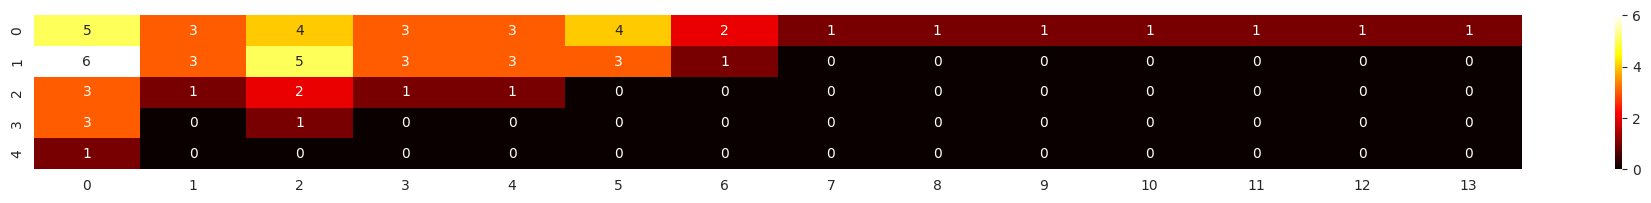

In [204]:
plt.figure(figsize=(24, 2))
sns.heatmap(agreement, annot=True, cmap='hot');

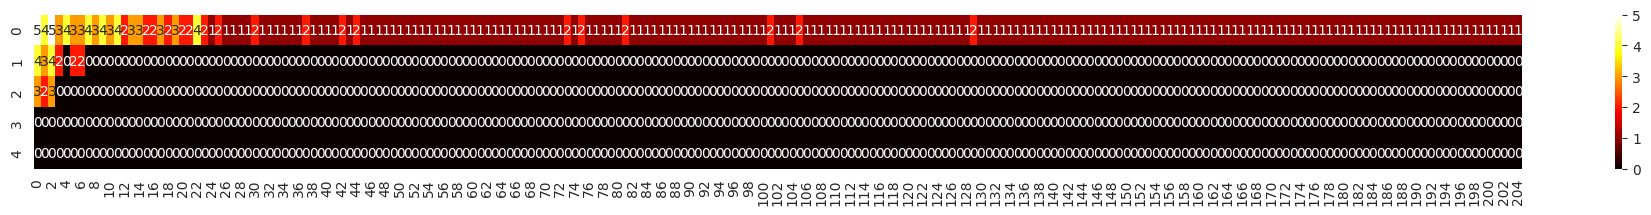

In [171]:
plt.figure(figsize=(24, 2))
sns.heatmap(agreement, annot=True, cmap='hot');

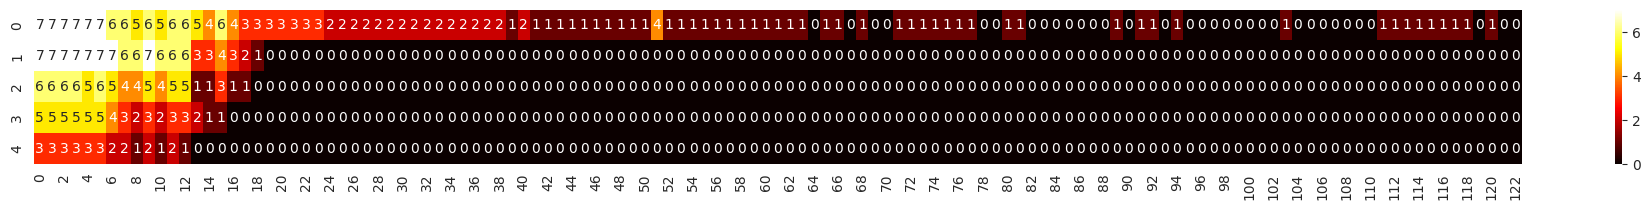

In [153]:
# plt.matshow(agreement[:,:20], cmap='gray');
plt.figure(figsize=(24, 2))
sns.heatmap(agreement, annot=True, cmap='hot');

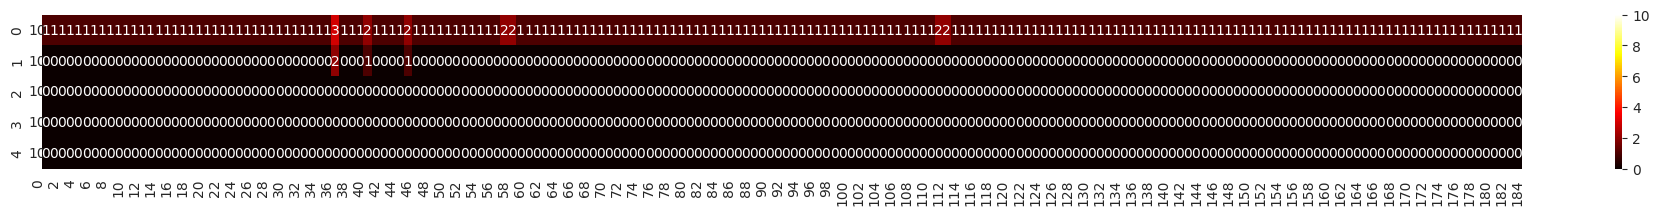

In [147]:
# plt.matshow(agreement[:,:20], cmap='gray');
plt.figure(figsize=(24, 2))
sns.heatmap(agreement, annot=True, cmap='hot');

In [74]:
clusterbag = Counter()
for aid, wt in neighbors:
	clusterbag.update(all_bags[aid].keys())
clusterbag = Counter({w: f for w, f in clusterbag.items() if importances[w] > 1e-8})
# total = sum(clusterbag.values())
# clusterbag = Counter({w: f / total for w, f in clusterbag.items()})
len(clusterbag)

620

In [75]:
total = 0.
print(tabulate([(w, v, (total := total + v)) for w, v in clusterbag.most_common(20)]))

--------  --  ---
myanmar   46   46
coup      39   85
power     36  121
military  25  146
army      25  171
san       24  195
suu       18  213
kyi       18  231
aung      17  248
detain    15  263
reddit     9  272
arrest     6  278
condemn    6  284
silver     6  290
burma      5  295
internet   5  300
gamestop   5  305
declare    4  309
economic   4  313
[          4  317
--------  --  ---


In [60]:
shells = []
shells.append(set(all_bags[aidorder[0]]))
for i in range(1, len(aidorder)):
	if len(shells[-1]) <= 1:
		break
	shells.append(set(all_bags[aidorder[i]]) & shells[-1])
len(shells)

20

In [61]:
shells[:20]

[{'"',
  '-',
  ':',
  'a',
  'and',
  'army',
  'aung',
  'clarin.com',
  'coup',
  "d'etat",
  'detain',
  'for',
  'in',
  'kyi',
  'myanmar',
  'power',
  'san',
  'suu',
  'take',
  'the',
  'year'},
 {'-',
  'a',
  'aung',
  'coup',
  'in',
  'kyi',
  'myanmar',
  'san',
  'suu',
  'the',
  'year'},
 {'-', 'aung', 'in', 'kyi', 'myanmar', 'san', 'suu', 'the'},
 {'-', 'aung', 'in', 'kyi', 'myanmar', 'san', 'suu'},
 {'-', 'aung', 'in', 'kyi', 'myanmar', 'san', 'suu'},
 {'-', 'aung', 'kyi', 'myanmar', 'san', 'suu'},
 {'-', 'aung', 'kyi', 'myanmar', 'san', 'suu'},
 {'-', 'aung', 'kyi', 'myanmar', 'san', 'suu'},
 {'-', 'aung', 'kyi', 'myanmar', 'san', 'suu'},
 {'-', 'aung', 'kyi', 'myanmar', 'san', 'suu'},
 {'-', 'aung', 'kyi', 'myanmar', 'san', 'suu'},
 {'-', 'aung', 'kyi', 'san', 'suu'},
 {'-', 'aung', 'kyi', 'san', 'suu'},
 {'-', 'aung', 'kyi', 'san', 'suu'},
 {'-', 'aung', 'kyi', 'san', 'suu'},
 {'-', 'aung', 'kyi', 'san', 'suu'},
 {'-', 'kyi', 'san', 'suu'},
 {'-', 'kyi', 'suu'},


In [62]:
print([len(s) for s in shells])

[21, 11, 8, 7, 7, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 4, 3, 3, 1]


In [39]:
param = 10
# param = 0.5

# clusters = cluster_results[param_values == param][0]

feats = sims

clusters = greedy_graph_clustering(G, aidorder.tolist(), thumb_factor=3., max_clusters=100)

print(Counter(clusters))

Counter({-1: 3212, 1: 177, 44: 139, 0: 124, 7: 94, 15: 83, 9: 80, 92: 73, 11: 69, 14: 62, 37: 60, 10: 59, 18: 58, 46: 55, 52: 44, 53: 44, 27: 42, 69: 41, 20: 40, 95: 38, 90: 37, 77: 36, 50: 34, 64: 33, 17: 32, 36: 32, 4: 30, 54: 30, 80: 29, 98: 29, 87: 28, 56: 27, 59: 26, 72: 26, 12: 24, 93: 22, 6: 21, 28: 21, 81: 19, 71: 17, 23: 16, 57: 16, 73: 16, 5: 15, 47: 15, 60: 15, 49: 13, 68: 13, 42: 12, 45: 12, 61: 11, 94: 11, 25: 10, 76: 10, 51: 9, 19: 8, 31: 8, 38: 7, 67: 7, 85: 7, 58: 6, 63: 6, 16: 5, 21: 5, 2: 4, 29: 4, 84: 4, 8: 3, 13: 3, 41: 3, 55: 3, 99: 3, 3: 2, 24: 2, 26: 2, 32: 2, 33: 2, 35: 2, 39: 2, 40: 2, 43: 2, 48: 2, 70: 2, 75: 2, 78: 2, 79: 2, 82: 2, 83: 2, 89: 2, 91: 2, 97: 2, 22: 1, 30: 1, 34: 1, 62: 1, 65: 1, 66: 1, 74: 1, 86: 1, 88: 1, 96: 1})


In [42]:
embedding = umap.UMAP(n_neighbors=5, n_components=2, metric='cosine', random_state=42).fit_transform(feats[clusters>0])

embedding_df = pd.DataFrame(embedding, columns=['x', 'y'])
embedding_df['cluster'] = [f'Cluster {i}' for i in clusters[clusters>0]]
embedding_df['title'] = [by_ID[aid].get('en-title', by_ID[aid]['title']) for aid in aidorder[clusters>0]]
embedding_df['importance'] = [prior_art_scores[aid] for aid in aidorder[clusters>0]]

fig = px.scatter(
    embedding_df, x='x', y='y',
    color='cluster',
	hover_data=['title', 'importance'],
	color_discrete_sequence=px.colors.qualitative.Light24,
    # title='UMAP projection of the headlines',
    # labels={'title': 'Headline', 'importance': 'Importance'}
)
# fig.update_traces(
#     hovertemplate="<b>%{customdata[0]}</b><br><br>x: %{x}<br>y: %{y}<br>Species: %{marker.color}"
# )
fig.show();

/home/fleeb/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [43]:
art_clusters = {cidx: aidorder[clusters==cidx].tolist() for cidx in set(clusters) if cidx >= 0}
tbl = []
for cidx, aids in art_clusters.items():
	
	arts = [by_ID[aid] for aid in aids]
	
	langs = Counter([art['language'] for art in arts])
	cats = Counter([i['category'] for art in arts for i in art['instances']])
	locs = Counter([i['location'] for art in arts for i in art['instances']])
	
	imp = sum(prior_art_scores[aid] for aid in aids)
	
	toptok = Counter()
	tokcounts = Counter()
	for art in arts:
		for w, f in all_bags[art['ID']].items():
			toptok[w] += importances[w] * f
			tokcounts[w] += f
	
	tbl.append([
		cidx,
		len(aids),
		imp,
		', '.join(f'{token!r}:{tokcounts[token]}' for token, f in toptok.most_common(10)),
		', '.join(f'{lang}:{f}' for lang, f in langs.most_common()),
		', '.join(f'{cat[:3]}:{f}' for cat, f in cats.most_common()),
		# ', '.join(f'{loc_names[loc]}:{f}' for loc, f in locs.most_common()),
	])
print(tabulate(sorted(tbl, key=lambda row: row[2], reverse=True)))

--  ---  -----------  ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------  -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------  -------------------------------------------------------
 0  124  0.0361315    'myanmar':48, 'suu':20, 'kyi':19, 'aung':19, 'gamestop':5, 'reddit':9, 'coup':41, 'burma':5, "d'etat":3, 'burmese':3                                                            en:24, es:14, zh:10, de:7, fr:6, ja:6, th:6, ko:5, sr:5, sv:4, bg:4, uk:3, ar:3, pl:3, hu:3, sk:2, el:2, he:2, ro:2, no:2, pt:2, ru:2, it:1, id:1, lv:1, lt:1, nl:1, cs:1, tr:1  gen:77, bus:24, tec:19, hea:13, ent:9, sci:6, spo:3
 1  177  0.0255384    'gamestop':54, 'reddit':6, 'wallstreetbet':3, 'bitcoin':63, 'melvin':4, 'blacklisting':3, 'dogecoin':4, 'a3':4, 'robinho

In [44]:
# clusters = cluster_results[np.argmin(db)]
clusters = cluster_results[param_values == 10][0]

# Clustering with KMeans
# Visualize the clusters (if you have 2D data or after using PCA for dimensionality reduction)
# pca = PCA(n_components=2)
# reduced_vectors = pca.fit_transform(headline_vectors)
# plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=clusters)
# plt.title('News Headlines Clustering')
# plt.xlabel('PCA Feature 1')
# plt.ylabel('PCA Feature 2')
# plt.show()

# Reduce dimensionality with UMAP
embedding = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='cosine').fit_transform(feats[clusters>0])

# Visualize the clusters
plt.scatter(embedding[:, 0], embedding[:, 1], c=clusters[clusters>0], cmap='Spectral')
plt.title('News Headlines Clustering with UMAP')
plt.xlabel('UMAP Feature 1')
plt.ylabel('UMAP Feature 2')
plt.colorbar()
plt.show()

# Print headlines and their respective cluster labels
# for i, cluster in enumerate(clusters):
#     print(f"Headline: '{headlines[i]}' is in cluster {cluster}")

NameError: name 'cluster_results' is not defined

In [43]:
deltas = {}
dates = list(daybags.keys())
valid_dates = []
for d1, d2 in tqdm(zip(dates[:-1], dates[1:]),total=len(dates)-1):
	if (d2 - d1).days == 1:
		valid_dates.append(d2)
		deltas[d2] = daybags[d2] - daybags[d1]
global_bag = Counter()
for date in valid_dates:
	global_bag.update(daybags[date])
len(deltas), len(global_bag)

  0%|          | 0/412 [00:00<?, ?it/s]

(371, 371, 477258)

In [56]:
dayidf = Counter()
for date, bag in tqdm(daybags.items()):
	dayidf.update(bag.keys())
dayidf = {w: np.log(len(daybags) / f)  for w, f in dayidf.items()}
daytotals = {d: sum(bag.values()) for d, bag in daybags.items()}
daytfidf = {day: Counter({w: f / daytotals[day] * dayidf[w] for w, f in bag.items()}) for day, bag in tqdm(daybags.items())}
len(daytfidf)

  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/413 [00:00<?, ?it/s]

413

In [57]:
target = datetime(2021, 2, 1).date()
# df[df['date'] == target]
len(daybags[target])

13674

In [61]:
print(tabulate(daytfidf[target].most_common(30)))

--------------  -----------
3885            0.000442286
1/31/21         0.000399841
-iss            0.000399841
gamestop        0.00035309
suu             0.000309284
ugc             0.000308742
crafoord        0.00029988
nightscout      0.00029988
kyi             0.000299367
wombat          0.000296615
wilmore         0.00027067
2/1/21          0.000265372
aung            0.00026076
tonbridge       0.0002499
nauru           0.000246993
635             0.000222965
kawaii          0.000222461
fibroblast      0.000219754
manhood         0.000217766
battleborn      0.000210677
micronutrients  0.000204321
calculations    0.000200977
letsupload      0.00019992
distractible    0.00019992
reddit          0.000194669
wallstreetbet   0.000193713
plitidepsin     0.000192386
solving         0.000184313
meganium        0.000176914
caleta          0.00016774
--------------  -----------


In [59]:
dt = deltas[target]
len(dt)

9073

In [25]:
keywords = Counter({w:f for w, f in dt.items() if any(not unicodedata.category(char).startswith('P') for char in w) and w not in stop_words})
len(keywords)

9005

In [44]:
wts = Counter({w: f / global_bag[w] for w, f in daybags[target].items()})
len(wts)

13674

In [63]:
print(tabulate(keywords.most_common(30)))

-------------  --
silver         82
liverpool      75
year           73
february       69
may            60
myanmar        49
international  44
1              43
transfer       42
coup           40
billion        36
eu             36
last           35
name           34
stock          34
science        33
get            33
channel        32
san            29
11             28
high           27
post           27
network        26
million        26
pfizer         26
military       26
investing.com  25
discover       25
speed          25
icloud         25
-------------  --


In [91]:
# corrs = {}
# for w , _ in tqdm(keywords.most_common()):
# 	for aid in date_aids[target]:
# 		bag = all_bags[aid]
# 		if w in bag:
# 			corrs.setdefault(w, Counter()).update(bag.keys())
# len(corrs)

present = {}
for aid in date_aids[target]:
	bag = all_bags[aid]
	for w in bag:
		if w in keywords:
			present.setdefault(w, set()).add(aid)
len(present)
ious = {w: Counter({w2: len(present[w].intersection(present[w2])) / len(present[w].union(present[w2])) for w2 in present if w != w2}) for w in tqdm(present)}
len(ious)

  0%|          | 0/9005 [00:00<?, ?it/s]

9005

In [109]:
importances = daytfidf[target]
scores = {w: Counter({w2: ious[w][w2] * np.sqrt(importances[w2] * importances[w]) for w2 in ious[w]}) for w in tqdm(ious)}

  0%|          | 0/9005 [00:00<?, ?it/s]

In [28]:
token = 'news'
print(tabulate([(w, s) for w, s in scores[token].most_common(30) if w != token]))

NameError: name 'scores' is not defined

In [140]:
G = nx.Graph()
for w, iou in tqdm(scores.items()):
	G.add_edges_from((w, w2, {'weight': f}) for w2, f in iou.items() if w > w2 and f > 9e-7)
len(G), len(G.edges)

  0%|          | 0/9005 [00:00<?, ?it/s]

(7365, 11623)

In [125]:
import community as community_louvain

In [126]:

# Compute the best partition using the Louvain algorithm
partition = community_louvain.best_partition(G)


In [127]:

# partition is a dictionary where the key is the node and the value is the cluster id
# for node, cluster_id in partition.items():
#     print(f'Node {node} is in cluster {cluster_id}')

# Optionally, you can also assess the quality of the partition
modularity = community_louvain.modularity(partition, G)
print(f"The modularity of the partition is {modularity}")

The modularity of the partition is 0.7202137514474273


In [135]:
clusters = {}
for node, cluster_id in partition.items():
	clusters.setdefault(cluster_id, []).append(node)
print([len(clid) for clid in clusters.values()])
len(clusters)

[1104, 127, 190, 1406, 433, 161, 213, 412, 226, 105, 74, 217, 263, 83, 78, 99, 63, 61, 45, 9, 42, 4, 26, 6]


24

In [138]:
clsid = partition[2906997]
clsid = 0
print(clsid, len(clusters[clsid]))
print(sorted(clusters[clsid], key=lambda aid: importances[aid], reverse=True))

0 1104
[2392207, 2905434, 2906164, 2906619, 2907832, 2909551, 2906262, 2907259, 2909715, 2910026, 2899241, 2900254, 2904967, 2905100, 2905488, 2905803, 2906433, 2906797, 2907548, 2908147, 2908295, 2904960, 2908778, 2910546, 2910804, 2910972, 2911033, 2906238, 2906523, 2908053, 2908110, 2908503, 2909427, 2911347, 1181063, 2369011, 2905166, 2905493, 2908336, 2908448, 2909109, 2911644, 2911797, 2911798, 2911860, 198353, 236513, 339466, 2568024, 571569, 571872, 2898471, 2905242, 2905972, 2906237, 2906801, 2906814, 2907010, 2907177, 2907298, 2907309, 2121444, 2907914, 2908773, 2908899, 2908958, 2910767, 2910904, 2911211, 916158, 2906055, 2906057, 2906124, 2906715, 2908724, 2911299, 2911349, 2899926, 2904930, 2905370, 2314, 2787772, 2900, 3509, 2899827, 151362, 2085300, 2905113, 2905848, 2906093, 2906310, 2906698, 2906760, 2906954, 2907256, 2907801, 2907925, 2908203, 2908414, 2908841, 2908892, 2908919, 2908984, 2908994, 2909025, 2909074, 2909547, 26090, 2909829, 2910438, 2910915, 2910969, 29

In [139]:
print(tabulate([(aid, by_ID[aid]['language'], by_ID[aid]['instances'][0]['collectedAt'].split('T')[0], by_ID[aid].get('en-title', by_ID[aid]['title'])) 
				for aid in sorted(clusters[clsid], key=lambda aid: importances[aid], reverse=True)]))

-------  --  ----------  -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
2392207  th  2020-12-28  Nation TV, Thailand's number 1 news station website | Economy - Nation TV, 24-hour news station
2905434  uk  2021-02-01  The expert told which websites should never be visited in public places - GSMinfo
2906164  ar  2021-02-01  A doctor warns against heating living things on a stove: it causes cancer - Colors of the Nation - Alwan
2906619  pt  2021-02-01  Website publishes alleged audios of Maradona's doctor: 'He's going to die shitting' - UOL Esporte
2907832  en  2021-02-01  The road from Meath to the 2021 Six Nations via Brisbane and Belfast - The42
2909551  ar  2021-02-01  Houria Farghali undergoes a delicate surgery that took 9 hours - Al Jadeed Official Website
2906262  en  2021-02-01  Pregnant S

In [440]:
# w, f = keywords.most_common()[0]
# w, f, any(not unicodedata.category(char).startswith('P') for char in w), w not in stop_words

In [26]:
print(tabulate(keywords.most_common(30)))

-------------  --
silver         82
liverpool      75
year           73
february       69
may            60
myanmar        49
international  44
1              43
transfer       42
coup           40
billion        36
eu             36
last           35
name           34
stock          34
science        33
get            33
channel        32
san            29
11             28
high           27
post           27
network        26
million        26
pfizer         26
military       26
investing.com  25
discover       25
speed          25
icloud         25
-------------  --


In [27]:
keywords['aung']

19

In [92]:
token = 'kyi'
included = [ID for ID, bag in all_bags.items() if token in bag]
len(included)

170

In [93]:
# matching instances
df[df['aid'].isin(included)][df['date'] == target]

/tmp/ipykernel_1128367/2288863398.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['aid'].isin(included)][df['date'] == target]


aid                                              title  \
5299712  2906997  Coup d'état in Myanmar: the army takes power "...   
5020331  2910418  Military coup in Burma and Suu Kyi: answers an...   
168220   2910066  Aung San Suu Kyi: The Myanmar Lady Who Became ...   
527302   2910866  Burma, coup d'état: Aung San Suu Kyi arrested....   
6164961  2906440  Army on the streets of Myanmar, Aung San Suu K...   
6164972  2907976  The army staged a coup in Myanmar, Prime Minis...   
2555915  2909178  [Aung San Suu Kyi was arrested] The Myanmar mi...   
4315455  2907695  Aung San Suu Kyi, Myanmar leader, detained in ...   
7240316  2910547  Aung San Suu Kyi and many others were detained...   
3811936  2910175  Coup in Myanmar: Aung San Suu Kyi calls for pr...   
4219037  2908388  Putsch in Myanmar. What Aung San Suu Kyi told ...   
3636948  2908218  Aung San Suu Kyi's appeal to the Burmese popul...   
4135306  2908083  A military coup took place in Myanmar. The cou...   
1908218  2911912  Burma: Head of government, Aung San Suu Kyi, a...   
5122607  2909302  Myanmar's leader Suu Kyi was arrested by the a...   
436612   2911692  Myanmar's military has detained leader Aun San...   
436611   2911692  Myanmar's military has detained leader Aun San...   
1607298  2907304  Myanmar military stages coup and declares stat...   
3480310  2911829  Military coup in Myanmar... Aung San Suu Kyi d...   
6736353  2908506  Myanmar's military stages coup, detains Aung S...   

                       source language               collectedAt location  \
5299712                Clarín       es 2021-02-01 14:11:00+00:00       ar   
5020331            Www.nzz.ch       de 2021-02-01 14:11:00+00:00       ch   
168220             News247.gr       el 2021-02-01 14:11:00+00:00       gr   
527302   Ilfattoquotidiano.it       it 2021-02-01 14:11:00+00:00       it   
6164961            Www.rts.rs       sr 2021-02-01 14:11:00+00:00       rs   
6164972              Danas.rs       sr 2021-02-01 14:11:00+00:00       rs   
2555915              Hket.com       zh 2021-02-01 14:11:00+00:00       hk   
4315455           Thecable.ng       en 2021-02-01 14:11:00+00:00       ng   
7240316              Sohu.com       zh 2021-02-01 14:11:00+00:00       cn   
3811936   Süddeutsche Zeitung       de 2021-02-01 14:11:00+00:00       de   
4219037             Pravda.sk       sk 2021-02-01 14:11:00+00:00       sk   
3636948           Dpgmedia.be       fr 2021-02-01 14:11:00+00:00       be   
4135306              BBC News       uk 2021-02-01 14:11:00+00:00       ua   
1908218                 2m.ma       fr 2021-02-01 14:11:00+00:00       ma   
5122607           Walla.co.il       he 2021-02-01 14:11:00+00:00       il   
436612                    CNN       en 2021-02-01 14:11:00+00:00       us   
436611                    CNN       en 2021-02-01 14:11:00+00:00       sa   
1607298                News24       en 2021-02-01 14:11:00+00:00       za   
3480310           Sedaily.com       ko 2021-02-01 14:11:00+00:00       kr   
6736353    The Times of India       en 2021-02-01 14:11:00+00:00       in   

        category          iid        date  
5299712  general  2906997-000  2021-02-01  
5020331  general  2910418-000  2021-02-01  
168220   general  2910066-000  2021-02-01  
527302   general  2910866-000  2021-02-01  
6164961  general  2906440-000  2021-02-01  
6164972  general  2907976-000  2021-02-01  
2555915  general  2909178-000  2021-02-01  
4315455  general  2907695-000  2021-02-01  
7240316  general  2910547-000  2021-02-01  
3811936  general  2910175-000  2021-02-01  
4219037  general  2908388-000  2021-02-01  
3636948  general  2908218-000  2021-02-01  
4135306  general  2908083-000  2021-02-01  
1908218  general  2911912-000  2021-02-01  
5122607  general  2909302-000  2021-02-01  
436612   general  2911692-001  2021-02-01  
436611   general  2911692-000  2021-02-01  
1607298  general  2907304-000  2021-02-01  
3480310  general  2911829-000  2021-02-01  
6736353  general  29085